In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" #hybridqnn_shallow
# train args
batch_size = 1
epochs = 10
LR = 0.001
n_samples_train = 200 #128
n_samples_test = 50 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR100" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ["forest","sea"] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['forest', 'sea']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 0.0006926810019649565 s


<Figure size 432x288 with 0 Axes>

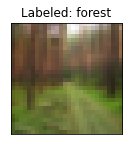

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        #n_filts_fc1 = int(((((input_resolution[0])/2)-4)/2)**2)*16 # +7
        n_filts_fc1 = 256
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
HybridQNN_Shallow(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)
Network init elapsed time: -0.0005611740052700043 s


Batch 0, Loss: -1.3623929023742676
Batch 1, Loss: -1.3720736503601074
Batch 2, Loss: -1.3887619972229004
Batch 3, Loss: 0.36625126004219055
Batch 4, Loss: -1.4028269052505493
Batch 5, Loss: -1.3941388130187988
Batch 6, Loss: -1.416565179824829
Batch 7, Loss: -1.3887298107147217
Batch 8, Loss: 0.44357624650001526
Batch 9, Loss: -1.4529292583465576
Batch 10, Loss: 0.4527019262313843
Batch 11, Loss: -1.391471266746521
Batch 12, Loss: -1.4209485054016113
Batch 13, Loss: -1.4367257356643677
Batch 14, Loss: 0.4491250813007355
Batch 15, Loss: -1.4491956233978271
Batch 16, Loss: 0.47512340545654297
Batch 17, Loss: -1.4568201303482056
Batch 18, Loss: 0.49237602949142456
Batch 19, Loss: -1.459964394569397
Batch 20, Loss: 0.4859585762023926
Batch 21, Loss: -1.5049482583999634
Batch 22, Loss: 0.4602780342102051
Batch 23, Loss: 0.4934549331665039
Batch 24, Loss: 0.513362467288971
Batch 25, Loss: 0.45359301567077637
Batch 26, Loss: 0.5058041214942932
Batch 27, Loss: -1.4709432125091553
Batch 28, Los

Batch 228, Loss: 0.4188058376312256
Batch 229, Loss: -1.4038524627685547
Batch 230, Loss: -1.3746132850646973
Batch 231, Loss: -1.3907124996185303
Batch 232, Loss: -1.3856308460235596
Batch 233, Loss: -1.3708367347717285
Batch 234, Loss: -1.3821921348571777
Batch 235, Loss: 0.39564380049705505
Batch 236, Loss: 0.3846701979637146
Batch 237, Loss: 0.38608527183532715
Batch 238, Loss: 0.3986636996269226
Batch 239, Loss: 0.37997469305992126
Batch 240, Loss: 0.4023094177246094
Batch 241, Loss: -1.3743582963943481
Batch 242, Loss: -1.3822643756866455
Batch 243, Loss: 0.3765608072280884
Batch 244, Loss: -1.4019594192504883
Batch 245, Loss: -1.3737740516662598
Batch 246, Loss: 0.38643068075180054
Batch 247, Loss: 0.3836946487426758
Batch 248, Loss: -1.394130825996399
Batch 249, Loss: 0.3905475437641144
Batch 250, Loss: 0.3929651975631714
Batch 251, Loss: -1.3728986978530884
Batch 252, Loss: 0.38278859853744507
Batch 253, Loss: 0.38345569372177124
Batch 254, Loss: 0.3764747977256775
Batch 255, 

Batch 53, Loss: -1.4020564556121826
Batch 54, Loss: 0.4079696238040924
Batch 55, Loss: 0.4024907350540161
Batch 56, Loss: -1.393786907196045
Batch 57, Loss: -1.3965513706207275
Batch 58, Loss: -1.3915069103240967
Batch 59, Loss: -1.3936184644699097
Batch 60, Loss: 0.3938482403755188
Batch 61, Loss: -1.3994624614715576
Batch 62, Loss: 0.3961449861526489
Batch 63, Loss: -1.3939099311828613
Batch 64, Loss: 0.39533939957618713
Batch 65, Loss: -1.4029643535614014
Batch 66, Loss: 0.3930857181549072
Batch 67, Loss: 0.3933814465999603
Batch 68, Loss: 0.3940165638923645
Batch 69, Loss: 0.3927984833717346
Batch 70, Loss: 0.39175698161125183
Batch 71, Loss: -1.395878553390503
Batch 72, Loss: -1.391056776046753
Batch 73, Loss: 0.4017525911331177
Batch 74, Loss: 0.40757372975349426
Batch 75, Loss: -1.3891041278839111
Batch 76, Loss: -1.3911046981811523
Batch 77, Loss: -1.3871310949325562
Batch 78, Loss: 0.39309170842170715
Batch 79, Loss: -1.3915469646453857
Batch 80, Loss: -1.3870888948440552
Batc

Batch 279, Loss: -1.4226489067077637
Batch 280, Loss: 0.4036082923412323
Batch 281, Loss: -1.4024360179901123
Batch 282, Loss: -1.3967269659042358
Batch 283, Loss: -1.4144506454467773
Batch 284, Loss: 0.40541085600852966
Batch 285, Loss: 0.40259432792663574
Batch 286, Loss: 0.39531847834587097
Batch 287, Loss: -1.4041094779968262
Batch 288, Loss: -1.4108893871307373
Batch 289, Loss: -1.4113961458206177
Batch 290, Loss: -1.4204492568969727
Batch 291, Loss: -1.4085791110992432
Batch 292, Loss: -1.4027037620544434
Batch 293, Loss: -1.430510401725769
Batch 294, Loss: 0.4189351499080658
Batch 295, Loss: 0.4146530032157898
Batch 296, Loss: 0.42374399304389954
Batch 297, Loss: -1.4271438121795654
Batch 298, Loss: -1.4149737358093262
Batch 299, Loss: 0.41904541850090027
Batch 300, Loss: -1.4099440574645996
Batch 301, Loss: 0.4391289949417114
Batch 302, Loss: 0.4157813787460327
Batch 303, Loss: 0.41487687826156616
Batch 304, Loss: 0.41952747106552124
Batch 305, Loss: -1.4182634353637695
Batch 3

Batch 106, Loss: -1.3964295387268066
Batch 107, Loss: -1.3991618156433105
Batch 108, Loss: -1.407484769821167
Batch 109, Loss: -1.4014487266540527
Batch 110, Loss: -1.3972623348236084
Batch 111, Loss: 0.37490057945251465
Batch 112, Loss: -1.4017854928970337
Batch 113, Loss: -1.369051456451416
Batch 114, Loss: 0.3707854151725769
Batch 115, Loss: -1.365692377090454
Batch 116, Loss: 0.4092620611190796
Batch 117, Loss: 0.3820072412490845
Batch 118, Loss: 0.4327285587787628
Batch 119, Loss: -1.3591110706329346
Batch 120, Loss: 0.403566837310791
Batch 121, Loss: -1.367992877960205
Batch 122, Loss: -1.4341068267822266
Batch 123, Loss: 0.3954926133155823
Batch 124, Loss: 0.40061402320861816
Batch 125, Loss: -1.402172327041626
Batch 126, Loss: 0.37561333179473877
Batch 127, Loss: -1.4023786783218384
Batch 128, Loss: 0.41862785816192627
Batch 129, Loss: 0.3968414068222046
Batch 130, Loss: 0.3772578537464142
Batch 131, Loss: 0.4019443094730377
Batch 132, Loss: 0.4281763434410095
Batch 133, Loss: 

Batch 331, Loss: -1.4100089073181152
Batch 332, Loss: 0.41488805413246155
Batch 333, Loss: -1.4297624826431274
Batch 334, Loss: 0.4540886878967285
Batch 335, Loss: 0.44275593757629395
Batch 336, Loss: 0.4103836417198181
Batch 337, Loss: -1.433623194694519
Batch 338, Loss: -1.4226312637329102
Batch 339, Loss: 0.4518476128578186
Batch 340, Loss: 0.4227011799812317
Batch 341, Loss: 0.41220057010650635
Batch 342, Loss: 0.4213421046733856
Batch 343, Loss: 0.40742865204811096
Batch 344, Loss: 0.4080190658569336
Batch 345, Loss: 0.4165215492248535
Batch 346, Loss: 0.4204193353652954
Batch 347, Loss: 0.40455129742622375
Batch 348, Loss: 0.41531991958618164
Batch 349, Loss: 0.41237136721611023
Batch 350, Loss: -1.4052330255508423
Batch 351, Loss: -1.396315097808838
Batch 352, Loss: 0.4191153645515442
Batch 353, Loss: -1.405561089515686
Batch 354, Loss: 0.393801748752594
Batch 355, Loss: 0.39288365840911865
Batch 356, Loss: 0.3948737382888794
Batch 357, Loss: -1.3898874521255493
Batch 358, Loss:

Batch 158, Loss: -1.3884871006011963
Batch 159, Loss: 0.40922975540161133
Batch 160, Loss: 0.4063093364238739
Batch 161, Loss: -1.405576467514038
Batch 162, Loss: -1.4139715433120728
Batch 163, Loss: -1.4113729000091553
Batch 164, Loss: -1.4127120971679688
Batch 165, Loss: 0.39464715123176575
Batch 166, Loss: 0.4235801696777344
Batch 167, Loss: 0.39816826581954956
Batch 168, Loss: 0.4152221083641052
Batch 169, Loss: -1.4137187004089355
Batch 170, Loss: 0.39887696504592896
Batch 171, Loss: -1.394395351409912
Batch 172, Loss: 0.4356296956539154
Batch 173, Loss: 0.41748568415641785
Batch 174, Loss: 0.3981224298477173
Batch 175, Loss: 0.4119739830493927
Batch 176, Loss: 0.4106672704219818
Batch 177, Loss: 0.4012886881828308
Batch 178, Loss: 0.40212947130203247
Batch 179, Loss: -1.3919894695281982
Batch 180, Loss: 0.41397249698638916
Batch 181, Loss: 0.4009995460510254
Batch 182, Loss: 0.38631635904312134
Batch 183, Loss: 0.4001326858997345
Batch 184, Loss: -1.3979876041412354
Batch 185, Lo

Batch 382, Loss: -1.4156506061553955
Batch 383, Loss: 0.42742884159088135
Batch 384, Loss: -1.413530707359314
Batch 385, Loss: -1.4352105855941772
Batch 386, Loss: 0.4061305522918701
Batch 387, Loss: -1.4263596534729004
Batch 388, Loss: 0.42766278982162476
Batch 389, Loss: 0.4418582022190094
Batch 390, Loss: -1.4198012351989746
Batch 391, Loss: 0.43131452798843384
Batch 392, Loss: 0.4153537452220917
Batch 393, Loss: 0.40999147295951843
Batch 394, Loss: 0.4110954999923706
Batch 395, Loss: 0.4069860875606537
Batch 396, Loss: 0.40840113162994385
Batch 397, Loss: -1.4086302518844604
Batch 398, Loss: 0.4171266257762909
Batch 399, Loss: 0.41648179292678833
Training [40%]	Loss: -0.4985
Batch 0, Loss: -1.4338555335998535
Batch 1, Loss: -1.4173243045806885
Batch 2, Loss: 0.4335828423500061
Batch 3, Loss: 0.4113594591617584
Batch 4, Loss: -1.4131876230239868
Batch 5, Loss: 0.410252183675766
Batch 6, Loss: 0.3985874354839325
Batch 7, Loss: 0.3941558599472046
Batch 8, Loss: 0.39284083247184753
Bat

Batch 209, Loss: 0.38432204723358154
Batch 210, Loss: -1.3910155296325684
Batch 211, Loss: 0.38491734862327576
Batch 212, Loss: 0.38033056259155273
Batch 213, Loss: -1.3897693157196045
Batch 214, Loss: 0.3841508626937866
Batch 215, Loss: 0.38532301783561707
Batch 216, Loss: -1.3902630805969238
Batch 217, Loss: -1.376871943473816
Batch 218, Loss: -1.383559226989746
Batch 219, Loss: -1.3787097930908203
Batch 220, Loss: 0.39261072874069214
Batch 221, Loss: -1.3788857460021973
Batch 222, Loss: -1.396632432937622
Batch 223, Loss: 0.37916916608810425
Batch 224, Loss: 0.378387987613678
Batch 225, Loss: 0.38550302386283875
Batch 226, Loss: 0.3782309293746948
Batch 227, Loss: -1.3938398361206055
Batch 228, Loss: 0.3874056339263916
Batch 229, Loss: -1.3850831985473633
Batch 230, Loss: 0.38090601563453674
Batch 231, Loss: -1.379278540611267
Batch 232, Loss: 0.3789743185043335
Batch 233, Loss: -1.3828163146972656
Batch 234, Loss: 0.38887616991996765
Batch 235, Loss: -1.4009475708007812
Batch 236, 

Batch 34, Loss: -1.3905956745147705
Batch 35, Loss: -1.3825339078903198
Batch 36, Loss: -1.3844237327575684
Batch 37, Loss: -1.3888534307479858
Batch 38, Loss: -1.3971424102783203
Batch 39, Loss: 0.3882763087749481
Batch 40, Loss: -1.381411075592041
Batch 41, Loss: 0.38673192262649536
Batch 42, Loss: 0.3827071189880371
Batch 43, Loss: 0.39695441722869873
Batch 44, Loss: -1.3839337825775146
Batch 45, Loss: -1.3851499557495117
Batch 46, Loss: 0.38625866174697876
Batch 47, Loss: 0.3872092366218567
Batch 48, Loss: 0.39248719811439514
Batch 49, Loss: -1.391654372215271
Batch 50, Loss: 0.3826829195022583
Batch 51, Loss: -1.3810235261917114
Batch 52, Loss: -1.3933624029159546
Batch 53, Loss: 0.3896852731704712
Batch 54, Loss: -1.3892905712127686
Batch 55, Loss: -1.3812813758850098
Batch 56, Loss: 0.38240277767181396
Batch 57, Loss: -1.3841586112976074
Batch 58, Loss: -1.3824894428253174
Batch 59, Loss: 0.38441595435142517
Batch 60, Loss: -1.385427474975586
Batch 61, Loss: -1.3833646774291992


Batch 260, Loss: 0.384304404258728
Batch 261, Loss: -1.3837753534317017
Batch 262, Loss: 0.3853951096534729
Batch 263, Loss: -1.3823487758636475
Batch 264, Loss: -1.3840715885162354
Batch 265, Loss: -1.3844534158706665
Batch 266, Loss: -1.3882932662963867
Batch 267, Loss: 0.3842512369155884
Batch 268, Loss: 0.38987094163894653
Batch 269, Loss: 0.39001062512397766
Batch 270, Loss: -1.3896586894989014
Batch 271, Loss: -1.3938610553741455
Batch 272, Loss: 0.3867490887641907
Batch 273, Loss: -1.3844670057296753
Batch 274, Loss: -1.3890058994293213
Batch 275, Loss: 0.38985559344291687
Batch 276, Loss: 0.3954257369041443
Batch 277, Loss: -1.389626383781433
Batch 278, Loss: -1.3960611820220947
Batch 279, Loss: 0.3870100677013397
Batch 280, Loss: 0.38618528842926025
Batch 281, Loss: -1.398482084274292
Batch 282, Loss: -1.3857029676437378
Batch 283, Loss: 0.39504915475845337
Batch 284, Loss: -1.397178053855896
Batch 285, Loss: -1.3918873071670532
Batch 286, Loss: 0.3935544788837433
Batch 287, L

Batch 87, Loss: -1.3888170719146729
Batch 88, Loss: -1.393251895904541
Batch 89, Loss: 0.3988754153251648
Batch 90, Loss: -1.3871304988861084
Batch 91, Loss: -1.4064126014709473
Batch 92, Loss: -1.3940359354019165
Batch 93, Loss: -1.3991100788116455
Batch 94, Loss: -1.3974583148956299
Batch 95, Loss: -1.3915185928344727
Batch 96, Loss: -1.4011728763580322
Batch 97, Loss: -1.3974963426589966
Batch 98, Loss: -1.3979014158248901
Batch 99, Loss: 0.39683112502098083
Batch 100, Loss: 0.4145124554634094
Batch 101, Loss: -1.3966853618621826
Batch 102, Loss: 0.41100165247917175
Batch 103, Loss: 0.39817506074905396
Batch 104, Loss: 0.4161093235015869
Batch 105, Loss: 0.3995484709739685
Batch 106, Loss: 0.39899688959121704
Batch 107, Loss: -1.3986124992370605
Batch 108, Loss: 0.3956276774406433
Batch 109, Loss: -1.40257728099823
Batch 110, Loss: 0.4097701609134674
Batch 111, Loss: -1.4021453857421875
Batch 112, Loss: 0.40904027223587036
Batch 113, Loss: -1.4041197299957275
Batch 114, Loss: -1.394

Batch 312, Loss: 0.40652674436569214
Batch 313, Loss: -1.3995437622070312
Batch 314, Loss: 0.39718884229660034
Batch 315, Loss: 0.40658265352249146
Batch 316, Loss: -1.414757490158081
Batch 317, Loss: -1.4064295291900635
Batch 318, Loss: -1.397348165512085
Batch 319, Loss: 0.39968106150627136
Batch 320, Loss: 0.41213932633399963
Batch 321, Loss: -1.4012255668640137
Batch 322, Loss: 0.4117877185344696
Batch 323, Loss: -1.3967735767364502
Batch 324, Loss: -1.394869327545166
Batch 325, Loss: -1.3933768272399902
Batch 326, Loss: 0.39594390988349915
Batch 327, Loss: 0.40480107069015503
Batch 328, Loss: 0.40515953302383423
Batch 329, Loss: -1.4101327657699585
Batch 330, Loss: -1.3973329067230225
Batch 331, Loss: -1.3934651613235474
Batch 332, Loss: -1.3955926895141602
Batch 333, Loss: -1.3984441757202148
Batch 334, Loss: 0.405317485332489
Batch 335, Loss: -1.406380534172058
Batch 336, Loss: -1.396101474761963
Batch 337, Loss: 0.4142283499240875
Batch 338, Loss: 0.4010593295097351
Batch 339, 

Batch 139, Loss: -1.3940913677215576
Batch 140, Loss: 0.3837241530418396
Batch 141, Loss: 0.3853647708892822
Batch 142, Loss: -1.388136625289917
Batch 143, Loss: 0.3929867744445801
Batch 144, Loss: -1.3796756267547607
Batch 145, Loss: -1.3924312591552734
Batch 146, Loss: 0.38150233030319214
Batch 147, Loss: -1.3841440677642822
Batch 148, Loss: 0.3831999599933624
Batch 149, Loss: -1.3835240602493286
Batch 150, Loss: -1.39236581325531
Batch 151, Loss: 0.384304404258728
Batch 152, Loss: 0.38325631618499756
Batch 153, Loss: 0.3811227083206177
Batch 154, Loss: -1.3850483894348145
Batch 155, Loss: 0.3863182067871094
Batch 156, Loss: -1.3827693462371826
Batch 157, Loss: -1.3802499771118164
Batch 158, Loss: 0.38232341408729553
Batch 159, Loss: -1.384346604347229
Batch 160, Loss: -1.3784711360931396
Batch 161, Loss: 0.38101452589035034
Batch 162, Loss: -1.3870954513549805
Batch 163, Loss: -1.3807833194732666
Batch 164, Loss: -1.393635869026184
Batch 165, Loss: -1.3819377422332764
Batch 166, Los

Batch 364, Loss: -1.378922700881958
Batch 365, Loss: 0.3787764012813568
Batch 366, Loss: -1.3826557397842407
Batch 367, Loss: 0.3804002106189728
Batch 368, Loss: 0.3799780309200287
Batch 369, Loss: 0.369737833738327
Batch 370, Loss: 0.3782289922237396
Batch 371, Loss: -1.379993200302124
Batch 372, Loss: -1.3811780214309692
Batch 373, Loss: 0.3771747052669525
Batch 374, Loss: -1.3738899230957031
Batch 375, Loss: 0.3884487450122833
Batch 376, Loss: 0.36249130964279175
Batch 377, Loss: 0.37191852927207947
Batch 378, Loss: -1.3645834922790527
Batch 379, Loss: -1.3736388683319092
Batch 380, Loss: 0.37212035059928894
Batch 381, Loss: -1.3770110607147217
Batch 382, Loss: -1.3602197170257568
Batch 383, Loss: -1.360329508781433
Batch 384, Loss: 0.38648563623428345
Batch 385, Loss: 0.37561312317848206
Batch 386, Loss: 0.3844495415687561
Batch 387, Loss: -1.3773763179779053
Batch 388, Loss: -1.3790373802185059
Batch 389, Loss: -1.3770843744277954
Batch 390, Loss: -1.3731448650360107
Batch 391, Lo

Batch 191, Loss: -1.4151989221572876
Batch 192, Loss: -1.402187705039978
Batch 193, Loss: 0.4174061715602875
Batch 194, Loss: -1.4114735126495361
Batch 195, Loss: 0.4149188995361328
Batch 196, Loss: 0.3996856212615967
Batch 197, Loss: 0.41591060161590576
Batch 198, Loss: -1.4026286602020264
Batch 199, Loss: 0.3998698890209198
Batch 200, Loss: -1.3993539810180664
Batch 201, Loss: 0.4035751223564148
Batch 202, Loss: -1.397498607635498
Batch 203, Loss: 0.3952929377555847
Batch 204, Loss: -1.3949638605117798
Batch 205, Loss: -1.3966193199157715
Batch 206, Loss: 0.406404972076416
Batch 207, Loss: 0.41020268201828003
Batch 208, Loss: 0.40969908237457275
Batch 209, Loss: -1.3939006328582764
Batch 210, Loss: 0.393694669008255
Batch 211, Loss: -1.4049370288848877
Batch 212, Loss: -1.4046993255615234
Batch 213, Loss: -1.393998146057129
Batch 214, Loss: 0.40392863750457764
Batch 215, Loss: -1.3950906991958618
Batch 216, Loss: -1.3962302207946777
Batch 217, Loss: -1.4037195444107056
Batch 218, Los

Batch 16, Loss: -1.3805866241455078
Batch 17, Loss: -1.393511176109314
Batch 18, Loss: -1.3836305141448975
Batch 19, Loss: -1.3912155628204346
Batch 20, Loss: 0.38427361845970154
Batch 21, Loss: 0.3824498951435089
Batch 22, Loss: 0.39177805185317993
Batch 23, Loss: 0.3824065029621124
Batch 24, Loss: 0.3839761018753052
Batch 25, Loss: 0.3817044496536255
Batch 26, Loss: 0.3837891221046448
Batch 27, Loss: -1.390413522720337
Batch 28, Loss: -1.3812246322631836
Batch 29, Loss: 0.38186970353126526
Batch 30, Loss: -1.3809359073638916
Batch 31, Loss: 0.38230758905410767
Batch 32, Loss: -1.3828706741333008
Batch 33, Loss: 0.37935590744018555
Batch 34, Loss: -1.3803858757019043
Batch 35, Loss: -1.3784846067428589
Batch 36, Loss: -1.3780521154403687
Batch 37, Loss: 0.3814544677734375
Batch 38, Loss: 0.38107332587242126
Batch 39, Loss: -1.380014181137085
Batch 40, Loss: 0.3877480626106262
Batch 41, Loss: 0.38251879811286926
Batch 42, Loss: -1.3808767795562744
Batch 43, Loss: -1.3794941902160645
Ba

Batch 243, Loss: 0.40794169902801514
Batch 244, Loss: -1.3692831993103027
Batch 245, Loss: 0.3831225335597992
Batch 246, Loss: 0.38304078578948975
Batch 247, Loss: -1.376150369644165
Batch 248, Loss: 0.38643136620521545
Batch 249, Loss: -1.409327507019043
Batch 250, Loss: 0.405036062002182
Batch 251, Loss: 0.4043567180633545
Batch 252, Loss: 0.3716154098510742
Batch 253, Loss: 0.3660808503627777
Batch 254, Loss: 0.39786067605018616
Batch 255, Loss: -1.3696162700653076
Batch 256, Loss: -1.3987557888031006
Batch 257, Loss: -1.4063246250152588
Batch 258, Loss: 0.36113208532333374
Batch 259, Loss: 0.4064100980758667
Batch 260, Loss: -1.3979010581970215
Batch 261, Loss: 0.37165892124176025
Batch 262, Loss: -1.3992154598236084
Batch 263, Loss: 0.3609795570373535
Batch 264, Loss: -1.3913886547088623
Batch 265, Loss: -1.3559821844100952
Batch 266, Loss: 0.3640144467353821
Batch 267, Loss: -1.406317949295044
Batch 268, Loss: -1.3674492835998535
Batch 269, Loss: 0.40738019347190857
Batch 270, Lo

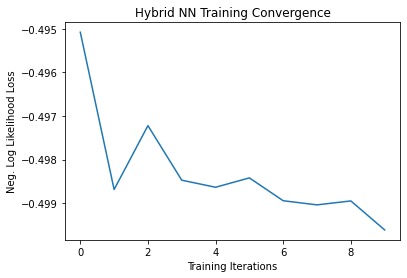

Training time: -0.00036855798680335283 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass
            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -0.4997
	Accuracy: 50.0%
Test time: 0.009940285002812743 s


<Figure size 432x288 with 0 Axes>

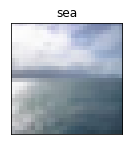

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 